# Import

## Import library

In [230]:
import os
import sys
import warnings
from tqdm import tqdm_notebook as tqdm 
from datetime import datetime 
from datetime import date, timedelta

import numpy as np
import pandas as pd

# 데이터 전처리
import re
from konlpy.tag import Okt
from konlpy.tag import Mecab
import rhinoMorph

# 데이터 분석
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

# 데이터 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
# import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# 현재 jupyter 위치를 PROJECT_DIR 추가
PROJECT_DIR = os.path.abspath(os.path.join(os.path.realpath('__file__'), '..'))
sys.path.insert(0, PROJECT_DIR)
DATA_DIR = PROJECT_DIR + '/data' # 데이터 위치 
print(DATA_DIR)

C:\Users\lime1\Documents\study\Python\project/data


## import

In [413]:
data_df = pd.read_excel(DATA_DIR +'/news_df_210205_v03_dna.xlsx')
data_df.head(2)

,media,date,title,article_original,url
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째… ABC방송 라이브 쇼에서 생중계\n \n\n\n\...,https://news.naver.com/main/read.nhn?mode=LSD&...
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단 BTS 이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트...,https://news.naver.com/main/read.nhn?mode=LSD&...


In [414]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   media             863 non-null    object
 1   date              863 non-null    object
 2   title             863 non-null    object
 3   article_original  863 non-null    object
 4   url               863 non-null    object
dtypes: object(5)
memory usage: 33.8+ KB


# 데이터 전처리

In [415]:
data_df['article_original'].iloc[0]

'2012년 싸이에 이어 두 번째… ABC방송 라이브 쇼에서 생중계\n \n\n\n\n 전 지구를 홀린 그룹입니다 \n \n\n 사회자의 소개와 함께 방탄소년단 BTS 이 모습을 드러냈다. 2019년의 마지막 날 미국 뉴욕 맨해튼 타임스스퀘어 무대에 선 것이다. 12월 31일 현지 시각 저녁 열리는 타임스스퀘어 볼드롭 대형 크리스털 볼이 신년 카운트다운과 함께 떨어지는 행사 을 보기 위해 몰려든 사람들로 이곳은 오전부터 부산스러웠다. 매년 이날만 되면 최소 100만명이 찾는 곳이지만 올해는 BTS 때문에 열기가 더욱 뜨거웠다. 뉴욕경찰 NYPD 은 이날 몰린 인파가 150만명이라고 추정했다.\n \n\n 한국 가수로 타임스스퀘어 새해맞이 무대에 오른 건 2012년 싸이에 이어 두 번째다. BTS는 밤 10시 38분부터 8분간 열정적인 춤과 노래로 시선을 사로잡았다. 8년 전 100만 인파가 싸이의 강남스타일 에 맞춰 말춤 을 췄던 것처럼 이날 타임스스퀘어에 모인 전 세계 아미 BTS 팬 들은 BTS가 작은 것들을 위한 시 와 Make It Right 를 부를 때 야광봉을 흔들며 한국어로 떼창을 선사했다. 공연을 마친 뒤 리더 RM은 여섯 살 때부터 나 홀로 집에 같은 영화에서 보던 광경이 눈앞에 있다 며 감격했다. 멤버들은 한목소리로 해피 뉴 이어 를 외쳤다.\n \n\n BTS 공연은 미국 최대 새해맞이 라이브 쇼인 ABC방송의 뉴 이어스 로킹 이브 New Year s Rocking Eve 를 통해서도 생중계됐다. 최정상급 가수들만 출연하는 유명 프로그램이다. 올해는 BTS 외에 컨트리 가수 샘 헌트와 싱어송 라이터 앨러니스 모리세트가 무대에 섰다. BTS는 2017년 사전 녹화를 통해 할리우드 무대에 출연했지만 타임스스퀘어 무대에 직접 선 것은 이번이 처음이다. 행사를 공동 진행한 라이언 시크레스트는 올해 타임스스퀘어의 절반은 BTS 팬으로 채워질 것 이라고 언급했다.\n \n\n BTS의 인기를 입증하듯 이날 오후부터 타임스스퀘어 주변 곳곳에선 BTS 노

기사 원문 데이터는 str 타입으로 개행문자(\n)를 포함하고 있습니다.  
이에 영문, 한글, 숫자를 제외한 불필요한 문자(\n ..)를 제거합니다.

In [416]:
# clearning
data_df['article_original'] = data_df['article_original'].apply(lambda x : re.sub(r'[^A-Za-z0-9가-힣. ]','',x))

In [417]:
data_df['article_original'][0]

'2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계  전 지구를 홀린 그룹입니다   사회자의 소개와 함께 방탄소년단 BTS 이 모습을 드러냈다. 2019년의 마지막 날 미국 뉴욕 맨해튼 타임스스퀘어 무대에 선 것이다. 12월 31일 현지 시각 저녁 열리는 타임스스퀘어 볼드롭 대형 크리스털 볼이 신년 카운트다운과 함께 떨어지는 행사 을 보기 위해 몰려든 사람들로 이곳은 오전부터 부산스러웠다. 매년 이날만 되면 최소 100만명이 찾는 곳이지만 올해는 BTS 때문에 열기가 더욱 뜨거웠다. 뉴욕경찰 NYPD 은 이날 몰린 인파가 150만명이라고 추정했다.  한국 가수로 타임스스퀘어 새해맞이 무대에 오른 건 2012년 싸이에 이어 두 번째다. BTS는 밤 10시 38분부터 8분간 열정적인 춤과 노래로 시선을 사로잡았다. 8년 전 100만 인파가 싸이의 강남스타일 에 맞춰 말춤 을 췄던 것처럼 이날 타임스스퀘어에 모인 전 세계 아미 BTS 팬 들은 BTS가 작은 것들을 위한 시 와 Make It Right 를 부를 때 야광봉을 흔들며 한국어로 떼창을 선사했다. 공연을 마친 뒤 리더 RM은 여섯 살 때부터 나 홀로 집에 같은 영화에서 보던 광경이 눈앞에 있다 며 감격했다. 멤버들은 한목소리로 해피 뉴 이어 를 외쳤다.  BTS 공연은 미국 최대 새해맞이 라이브 쇼인 ABC방송의 뉴 이어스 로킹 이브 New Year s Rocking Eve 를 통해서도 생중계됐다. 최정상급 가수들만 출연하는 유명 프로그램이다. 올해는 BTS 외에 컨트리 가수 샘 헌트와 싱어송 라이터 앨러니스 모리세트가 무대에 섰다. BTS는 2017년 사전 녹화를 통해 할리우드 무대에 출연했지만 타임스스퀘어 무대에 직접 선 것은 이번이 처음이다. 행사를 공동 진행한 라이언 시크레스트는 올해 타임스스퀘어의 절반은 BTS 팬으로 채워질 것 이라고 언급했다.  BTS의 인기를 입증하듯 이날 오후부터 타임스스퀘어 주변 곳곳에선 BTS 노래가 흘러나왔고 행인들이 노래에 맞춰 몸을 흔들었다. 새벽 1시

아래 토큰화 시 불용어를 삭제하기 위해 stop word를 파일을 불러옵니다.   
stop word 출처: https://www.ranks.nl/stopwords/korean  

In [8]:
stopwords = open(DATA_DIR+'/stopwords_kor.txt','r', encoding='utf-8').read().split('\n')
stopwords[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']

# 단어 토큰화

rhinoMorph 패키지를 사용하며, 불용어와 1글자 이하는 제거합니다.  
※ 주의: konlpy 패키지와 rhinoMorph 패키지를 함께 실행하면 에러 발생함

In [9]:
# 실질형태소, 어말어미(emoi) 제외, NNG+NNP, XR+하: 동사로 변형(xrVv) 안함
# 품사정보: https://m.blog.naver.com/lingua/220143966152
# NNG: 일반명사 / NNP: 고유명사 / (VV: 동사) / VA: 형용사 
# (XR: 어근 / IC: 감탄사 / MM: 관형사 / MAG: 일반부사 / MAJ: 접속부사)
rhino = rhinoMorph.startRhino()
data_df['token_rhino'] = data_df.article_original.apply(lambda x: rhinoMorph.onlyMorph_list(rhino, x, pos=['NNG','NNP','VA'], combineN=True)) # eomi=True, xrVv=True))
data_df.token_rhino = data_df.token_rhino.apply(lambda x : [w for w in x if x not in stopwords if len(w) >1])  # 불용어 제거
data_df.head(2)

filepath:  C:\Users\lime1\anaconda3\Lib\site-packages
classpath:  C:\Users\lime1\anaconda3\Lib\site-packages\rhinoMorph/lib/rhino.jar
RHINO started!


,media,date,title,article_original,url,token_rhino
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방송, 라이브, 생중계, 지구, 그룹, 사회자, 소개, 방탄소년단, 모습, 마지막..."
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단 BTS 이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방탄소년단, 미국, 선정, 음악, 변화, 아티스트, 현지시각, 자신, 음악, 장르..."


In [10]:
idx = 0
print('\n === ', idx, ' ===\n')
print('\n-- article_original --\n', data_df['article_original'].iloc[idx])
print('\n-- rhinoMorph --\n', data_df['token_rhino'].iloc[idx])


 ===  0  ===


-- article_original --
 2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계  전 지구를 홀린 그룹입니다   사회자의 소개와 함께 방탄소년단 BTS 이 모습을 드러냈다 2019년의 마지막 날 미국 뉴욕 맨해튼 타임스스퀘어 무대에 선 것이다 12월 31일 현지 시각 저녁 열리는 타임스스퀘어 볼드롭 대형 크리스털 볼이 신년 카운트다운과 함께 떨어지는 행사 을 보기 위해 몰려든 사람들로 이곳은 오전부터 부산스러웠다 매년 이날만 되면 최소 100만명이 찾는 곳이지만 올해는 BTS 때문에 열기가 더욱 뜨거웠다 뉴욕경찰 NYPD 은 이날 몰린 인파가 150만명이라고 추정했다  한국 가수로 타임스스퀘어 새해맞이 무대에 오른 건 2012년 싸이에 이어 두 번째다 BTS는 밤 10시 38분부터 8분간 열정적인 춤과 노래로 시선을 사로잡았다 8년 전 100만 인파가 싸이의 강남스타일 에 맞춰 말춤 을 췄던 것처럼 이날 타임스스퀘어에 모인 전 세계 아미 BTS 팬 들은 BTS가 작은 것들을 위한 시 와 Make It Right 를 부를 때 야광봉을 흔들며 한국어로 떼창을 선사했다 공연을 마친 뒤 리더 RM은 여섯 살 때부터 나 홀로 집에 같은 영화에서 보던 광경이 눈앞에 있다 며 감격했다 멤버들은 한목소리로 해피 뉴 이어 를 외쳤다  BTS 공연은 미국 최대 새해맞이 라이브 쇼인 ABC방송의 뉴 이어스 로킹 이브 New Year s Rocking Eve 를 통해서도 생중계됐다 최정상급 가수들만 출연하는 유명 프로그램이다 올해는 BTS 외에 컨트리 가수 샘 헌트와 싱어송 라이터 앨러니스 모리세트가 무대에 섰다 BTS는 2017년 사전 녹화를 통해 할리우드 무대에 출연했지만 타임스스퀘어 무대에 직접 선 것은 이번이 처음이다 행사를 공동 진행한 라이언 시크레스트는 올해 타임스스퀘어의 절반은 BTS 팬으로 채워질 것 이라고 언급했다  BTS의 인기를 입증하듯 이날 오후부터 타임스스퀘어 주변 곳곳에선 BTS 노래가 흘러나왔고 행인

# 단어 분포 확인

In [11]:
# rhino
words_list = [word for sent in data_df['token_rhino'] for word in sent]
print(words_list[:20])
vocab = Counter(words_list)
# vocab.most_common(50)

['방송', '라이브', '생중계', '지구', '그룹', '사회자', '소개', '방탄소년단', '모습', '마지막', '미국', '뉴욕', '맨해튼', '타임스스퀘어', '무대', '현지', '시각', '저녁', '타임스스퀘어', '드롭']


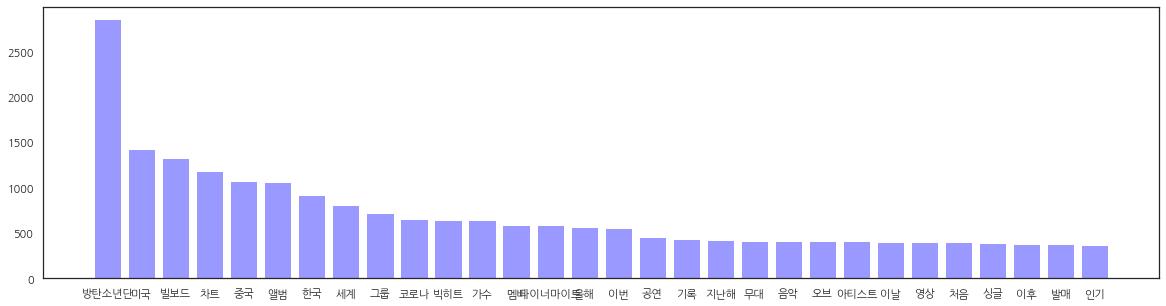

In [18]:
# rhinoMorph ----
vocab_most50_df = pd.DataFrame(vocab.most_common(100), columns=['vocab','count'])
num = 30
sorted_keys = vocab_most50_df['vocab'][:num]
sorted_values = vocab_most50_df['count'][:num]

plt.figure(figsize=(20,5))
plt.rc('font', family='NanumGothic') 
plt.bar(range(num), sorted_values, color='#9999ff')
plt.xticks(range(num), sorted_keys)
plt.show()

# 토픽 모델링- LDA
- Latent Dirichlet Allocation
- 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합할 확률로 추정하여 토픽 추출
- 문서들이 토픽들의 혼합으로 구성되어져 있으며, 토픽들은 확률분포에 기반하여 단어를 생성한다고 가정함.

<br></br>

- 사용자 알고리즘 지정사항: 토픽 개수
- 모든 문서의 모든 단어에 대하여 아래 사항 반복 진행
    - 어떤 문서의 각 단어 w는 자신은 잘못된 토픽에 할당되어져 있지만, 다른 단어들은 전부 올바른 토픽에 할당되어져 있는 상태라고 가정.
    - 이에 따라 단어 w는 아래 두가지 기준에 따라 토픽 재할당
        - 문서 d의 단어들 중 토픽 t에 해당하는 단어 비율
        - 단어 w를 갖고 있는 모든 문서들 중 토픽 t가 할당된 비율

## sklearn LDA

In [148]:
# 각 토픽별로 연관도가 높은 순으로 word 나열
def get_topics(model, feature_names, n=50):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #', topic_idx)  # topic num
        tlist = [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[::-1][:n]] # topic 단어, 연관도
        print(tlist[:20])
        topic_list.append(tlist)

    return topic_list

In [149]:
def sklLDA(data, num_topics):
    # CountVectorizer : sklearn 제공
    # - max_df: 전체 문서에 걸쳐서 너무 높은 빈도수를 가지는 단어를 제외하기 위함 
    # - min_df: 전체 문서에 걸쳐서 너무 낮은 빈도수를 가지는 단어를 제외하기 위함
    # - max_features : 추출하는 feature의 개수 제한. 정수 지정
    cnt_vect = CountVectorizer(max_df=2000, lowercase=False, min_df=10, stop_words=stopwords)
    cnt_matrix = cnt_vect.fit_transform(data.apply(lambda x : ' '.join(w for w in x)))

    # LDA (LatentDirichletAllocation) : sklearn 제공
    # - n_components 파라미터를 이용해 이 토픽 개수를 조정함
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda_topic = lda_model.fit_transform(cnt_matrix)
    feature_names = cnt_vect.get_feature_names()
    print(lda_model.components_.shape)
#     print(lda_model.components_)
    topic_list = get_topics(lda_model, feature_names)
    
    return lda_model, cnt_matrix, cnt_vect, topic_list

In [150]:
# 토픽 개수: 7
TOPICS_NUM = 7
lda_model, cnt_matrix, cnt_vect, topic_list = sklLDA(data_df.token_rhino, TOPICS_NUM)

(7, 1604)
Topic # 0
[('중국', 1058.13), ('한국', 253.24), ('미국', 238.8), ('네티즌', 203.11), ('발언', 164.59), ('관련', 162.83), ('한국전쟁', 149.92), ('역사', 147.3), ('논란', 127.84), ('소감', 127.38), ('방탄소년단', 125.51), ('전쟁', 124.75), ('희생', 124.14), ('한미', 118.41), ('양국', 116.35), ('환구시보', 110.14), ('수상', 99.78), ('문제', 82.58), ('기사', 81.55), ('고난', 78.14)]
Topic # 1
[('미국', 239.41), ('방탄소년단', 210.86), ('한국', 169.12), ('올해', 153.35), ('세계', 147.28), ('패션', 117.92), ('트위터', 105.18), ('영화', 97.29), ('감독', 88.36), ('기생충', 85.95), ('케이팝', 82.83), ('흑인', 75.14), ('아카데미', 74.78), ('수상', 71.17), ('남성', 70.57), ('경찰', 62.14), ('시상식', 61.9), ('이름', 61.54), ('여성', 59.85), ('인물', 57.08)]
Topic # 2
[('방탄소년단', 1452.94), ('빌보드', 1255.08), ('차트', 1182.45), ('앨범', 1017.33), ('미국', 810.49), ('다이너마이트', 589.44), ('가수', 479.88), ('그룹', 471.57), ('기록', 387.19), ('싱글', 385.36), ('발매', 356.67), ('오브', 316.89), ('정상', 294.3), ('한국', 275.22), ('연속', 267.6), ('처음', 264.08), ('후보', 260.21), ('판매량', 260.15), ('부문', 248.9), ('올해'

In [16]:
# LDA 시각화하기  
# - 각 원과의 거리는 각 토픽들이 서로 얼마나 다른지를 보여줍니다. 
# - 만약 두 개의 원이 겹친다면, 이 두 개의 토픽은 유사한 토픽이라는 의미입니다. 
# pyLDAvis.sklearn.prepare(lda_model, dtm_matrix, vectorizer)
# - lda_model = calculated topic model
# - dtm_matrix = document word frequency matrix
# - vectorizer = word space

pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, cnt_matrix, cnt_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

gensim 패키지와 sklearn 패키지(Count Vectorizer, TF-IDF Vactorizer)에서 제공하는 LDA(Latent Dirichlet Allocation) 모델을 활용해 토픽을 5~8가지로 나눴을 때의 분포도를 pyLDAvis 패키지를 활용하여 시각화를 통해 확인하였다.  
결과적으로 고르게 확산 분포되면서도 교집합이 발생하는 경우가 적은 경우는 sklearn 패키지에서 제공하는 LDA 모델을 사용하며, 토픽을 7개로 설정할 때인 것으로 보인다.  
*** 이에 Count Vectorizers 클래스로 만든 BoW로 klearn 패키지 LDA 모듈, 토픽수 7개로 적용하고자 한다. ***

아래와 같은 방법으로 적정 토픽 수도 구할 수 있다.

In [32]:
import logging
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3): 
    """ 
    Compute c_v coherence for various number of topics 
    
    Parameters: 
    ---------- 
    dictionary : Gensim dictionary 
    corpus : Gensim corpus 
    texts : List of input texts 
    limit : Max num of topics 
    
    Returns: 
    ------- 
    model_list : List of LDA topic models 
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics 
    """ 
    coherence_values = [] 
    model_list = [] 
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=0) 
        model_list.append(model) 
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') 
        coherence_values.append(coherencemodel.get_coherence()) 
    return model_list, coherence_values 

# 출처: https://joyhong.tistory.com/138#topic=0&lambda=1&term= [옳은 길로..]

In [33]:
processed_data = data_df.token_rhino

# 정수 인코딩과 빈도수 생성 
dictionary = corpora.Dictionary(processed_data) 

# 출현빈도가 적거나 자주 등장하는 단어는 제거 
dictionary.filter_extremes(no_below=10)#, no_above=0.05) 
corpus = [dictionary.doc2bow(text) for text in processed_data] 
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus)) 

logging.basicConfig(format='%(message)s', level=logging.INFO) 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 

# 최적의 토픽 수 찾기 
limit = 12
start = 5
step = 1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 

2021-02-21 22:32:06,271 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-21 22:32:06,416 : INFO : built Dictionary(14217 unique tokens: ['NEW', '가수', '강남스타일', '거대', '곳곳']...) from 863 documents (total 131697 corpus positions)
2021-02-21 22:32:06,427 : INFO : discarding 12591 tokens: [('NEW', 6), ('광경', 2), ('눈앞', 4), ('뉴욕경찰', 1), ('뉴욕매거진', 1), ('라이언', 4), ('라이터', 1), ('로킹', 2), ('맨해튼', 7), ('모리세트', 1)]...
2021-02-21 22:32:06,428 : INFO : keeping 1626 tokens which were in no less than 10 and no more than 431 (=50.0%) documents
2021-02-21 22:32:06,433 : INFO : resulting dictionary: Dictionary(1626 unique tokens: ['가수', '강남스타일', '거대', '곳곳', '공동']...)
2021-02-21 22:32:06,490 : INFO : using symmetric alpha at 0.2
2021-02-21 22:32:06,490 : INFO : using symmetric eta at 0.2
2021-02-21 22:32:06,491 : INFO : using serial LDA version on this node
2021-02-21 22:32:06,492 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 863 do

Number of unique tokens: 1626
Number of documents: 863


2021-02-21 22:32:07,492 : INFO : -7.992 per-word bound, 254.5 perplexity estimate based on a held-out corpus of 863 documents with 93676 words
2021-02-21 22:32:07,494 : INFO : PROGRESS: pass 0, at document #863/863
2021-02-21 22:32:08,229 : INFO : topic #0 (0.200): 0.017*"빌보드" + 0.013*"빅히트" + 0.012*"차트" + 0.010*"가수" + 0.009*"세계" + 0.009*"한국" + 0.008*"그룹" + 0.008*"코로나" + 0.008*"다이너마이트" + 0.007*"앨범"
2021-02-21 22:32:08,230 : INFO : topic #1 (0.200): 0.019*"중국" + 0.012*"빌보드" + 0.012*"앨범" + 0.011*"한국" + 0.010*"세계" + 0.008*"올해" + 0.008*"그룹" + 0.008*"차트" + 0.006*"부문" + 0.006*"수상"
2021-02-21 22:32:08,231 : INFO : topic #2 (0.200): 0.026*"차트" + 0.024*"빌보드" + 0.013*"앨범" + 0.009*"다이너마이트" + 0.009*"가수" + 0.008*"코로나" + 0.008*"정상" + 0.008*"한국" + 0.008*"싱글" + 0.008*"기록"
2021-02-21 22:32:08,231 : INFO : topic #3 (0.200): 0.033*"중국" + 0.017*"한국" + 0.010*"멤버" + 0.009*"영상" + 0.008*"세계" + 0.007*"올해" + 0.007*"앨범" + 0.006*"그룹" + 0.006*"이번" + 0.005*"코로나"
2021-02-21 22:32:08,232 : INFO : topic #4 (0.200): 0.0

2021-02-21 22:32:27,832 : INFO : topic #5 (0.143): 0.015*"빌보드" + 0.012*"차트" + 0.011*"세계" + 0.011*"앨범" + 0.010*"멤버" + 0.010*"한국" + 0.009*"다이너마이트" + 0.009*"코로나" + 0.007*"그룹" + 0.007*"이번"
2021-02-21 22:32:27,833 : INFO : topic diff=1.053466, rho=1.000000
2021-02-21 22:32:27,837 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-02-21 22:32:30,710 : INFO : 1 batches submitted to accumulate stats from 64 documents (1543 virtual)
2021-02-21 22:32:30,722 : INFO : 2 batches submitted to accumulate stats from 128 documents (4293 virtual)
2021-02-21 22:32:30,732 : INFO : 3 batches submitted to accumulate stats from 192 documents (6901 virtual)
2021-02-21 22:32:30,740 : INFO : 4 batches submitted to accumulate stats from 256 documents (9737 virtual)
2021-02-21 22:32:30,748 : INFO : 5 batches submitted to accumulate stats from 320 documents (12370 virtual)
2021-02-21 22:32:30,757 : INFO : 6 batches submitted to accumulat

2021-02-21 22:32:51,955 : INFO : 6 batches submitted to accumulate stats from 384 documents (13538 virtual)
2021-02-21 22:32:51,965 : INFO : 7 batches submitted to accumulate stats from 448 documents (16414 virtual)
2021-02-21 22:32:52,470 : INFO : 8 batches submitted to accumulate stats from 512 documents (18874 virtual)
2021-02-21 22:32:52,761 : INFO : 9 batches submitted to accumulate stats from 576 documents (21693 virtual)
2021-02-21 22:32:53,080 : INFO : 10 batches submitted to accumulate stats from 640 documents (23994 virtual)
2021-02-21 22:32:53,208 : INFO : 11 batches submitted to accumulate stats from 704 documents (26724 virtual)
2021-02-21 22:32:53,420 : INFO : 12 batches submitted to accumulate stats from 768 documents (30154 virtual)
2021-02-21 22:32:53,563 : INFO : 13 batches submitted to accumulate stats from 832 documents (33325 virtual)
2021-02-21 22:32:53,897 : INFO : 14 batches submitted to accumulate stats from 896 documents (37831 virtual)
2021-02-21 22:32:56,345

2021-02-21 22:33:19,858 : INFO : 14 batches submitted to accumulate stats from 896 documents (37725 virtual)
2021-02-21 22:33:22,497 : INFO : 7 accumulators retrieved from output queue
2021-02-21 22:33:22,523 : INFO : accumulated word occurrence stats for 49475 virtual documents


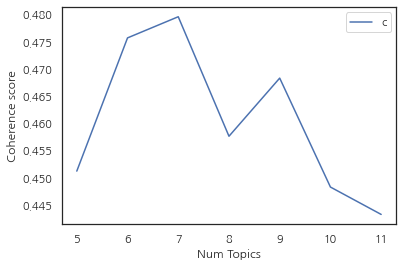

In [34]:
x = range(start, limit, step) 
plt.plot(x, coherence_values) 
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

In [151]:
pd.DataFrame(topic_list).T

,0,1,2,3,4,5,6
0,"(중국, 1058.13)","(미국, 239.41)","(방탄소년단, 1452.94)","(공연, 400.14)","(병역, 199.64)","(빅히트, 530.13)","(방탄소년단, 533.4)"
1,"(한국, 253.24)","(방탄소년단, 210.86)","(빌보드, 1255.08)","(코로나, 351.91)","(의원, 144.14)","(청년, 209.4)","(멤버, 286.13)"
2,"(미국, 238.8)","(한국, 169.12)","(차트, 1182.45)","(콘서트, 265.04)","(방탄소년단, 131.95)","(상장, 165.06)","(세계, 269.76)"
3,"(네티즌, 203.11)","(올해, 153.35)","(앨범, 1017.33)","(방탄소년단, 241.61)","(연기, 109.1)","(방탄소년단, 156.73)","(영상, 269.2)"
4,"(발언, 164.59)","(세계, 147.28)","(미국, 810.49)","(무대, 197.87)","(문제, 108.69)","(대통령, 138.32)","(코로나, 226.45)"
5,"(관련, 162.83)","(패션, 117.92)","(다이너마이트, 589.44)","(서울, 139.16)","(병역특례, 108.14)","(공모, 117.14)","(사람, 192.55)"
6,"(한국전쟁, 149.92)","(트위터, 105.18)","(가수, 479.88)","(세계, 117.28)","(장관, 106.29)","(대표, 113.88)","(한국, 174.7)"
7,"(역사, 147.3)","(영화, 97.29)","(그룹, 471.57)","(온라인, 109.24)","(분야, 99.87)","(엔터테인먼트, 105.72)","(트위터, 164.28)"
8,"(논란, 127.84)","(감독, 88.36)","(기록, 387.19)","(투어, 108.86)","(미술, 94.14)","(매출, 83.62)","(인기, 157.43)"
9,"(소감, 127.38)","(기생충, 85.95)","(싱글, 385.36)","(빅히트, 108.29)","(전시, 86.45)","(빅히트엔터테인먼트, 82.73)","(메시지, 147.42)"


In [203]:
# word_set : topic 별 단어만 set 형태로 저장
word_set = [ {w[0] for w in t} for t in topic_list ] 
# print(word_set)

# compare : 하나의 토픽과 나머지 토픽과 중복되는 단어 추출
inter_list = []
for i in range(len(word_set)):
    intersect_vocab = set()
    for j, s in enumerate(word_set):
        if i == j:
            continue
        else:
            intersect_vocab.update(word_set[i] & s)
    inter_list.append(intersect_vocab)

# 토픽 별 유일한 단어만 남기기
unique_twords= [word_set[i] - inter_list[i] for i in range(len(word_set))]
pd.DataFrame(unique_twords).T

# 토픽 단어 별 유사도, 빈도 보이기
unique_sort_twords = []
for i, t in enumerate(topic_list):
    tmp = [ w for w in t if w[0] in unique_twords[i] ]
    unique_sort_twords.append(tmp)

# pd.DataFrame(unique_sort_twords).T

# # 중복 제거 후 토픽 별로 None 없이 모두 값이 있는 경우로 토픽 단어 정리
new_topic_df = pd.DataFrame(unique_sort_twords).T.iloc[:min(map(len,unique_sort_twords))]
new_topic_df

,0,1,2,3,4,5,6
0,"(중국, 1058.13)","(패션, 117.92)","(차트, 1182.45)","(공연, 400.14)","(병역, 199.64)","(상장, 165.06)","(메시지, 147.42)"
1,"(네티즌, 203.11)","(영화, 97.29)","(앨범, 1017.33)","(콘서트, 265.04)","(의원, 144.14)","(공모, 117.14)","(이야기, 131.67)"
2,"(발언, 164.59)","(감독, 88.36)","(다이너마이트, 589.44)","(투어, 108.86)","(연기, 109.1)","(매출, 83.62)","(마음, 128.81)"
3,"(한국전쟁, 149.92)","(기생충, 85.95)","(기록, 387.19)","(슈가, 106.45)","(병역특례, 108.14)","(주식, 82.14)","(다양, 121.95)"
4,"(역사, 147.3)","(케이팝, 82.83)","(싱글, 385.36)","(정국, 91.43)","(장관, 106.29)","(주가, 80.12)","(새롭, 119.61)"
5,"(소감, 127.38)","(흑인, 75.14)","(발매, 356.67)","(라이브, 82.94)","(분야, 99.87)","(회사, 79.29)","(유튜브, 118.6)"
6,"(전쟁, 124.75)","(아카데미, 74.78)","(정상, 294.3)","(확산, 75.32)","(미술, 94.14)","(방시혁, 65.54)","(해외, 115.38)"
7,"(희생, 124.14)","(남성, 70.57)","(연속, 267.6)","(일정, 74.85)","(전시, 86.45)","(청약, 58.14)","(광고, 108.68)"
8,"(한미, 118.41)","(경찰, 62.14)","(판매량, 260.15)","(방방콘, 72.14)","(병역법, 85.14)","(사업, 56.5)","(지금, 107.95)"
9,"(양국, 116.35)","(이름, 61.54)","(부문, 248.9)","(사회적, 70.38)","(국회, 78.14)","(투자자, 56.14)","(세대, 99.14)"


In [206]:
# getTopicCount를 통해 문서 내 토픽 별 포함된 단어 숫자 count
# - doc: 1개의 문서, 단어로, list 타입
# - topic_list: 토픽 별로 단어가 list로 묶여 있는 list 타입
def getTopicCount(doc, topic_list):  
    cnt_per_topic=np.zeros(len(topic_list), dtype=int)
    for i,words in enumerate(topic_list):
        for word in words:
            if word in doc:
                cnt_per_topic[i] +=1
    return cnt_per_topic

In [208]:
# 토픽 별 단어 포함 수를 비교해 높은 값을 토픽 값으로 함
# - max : 제일 높은 토픽 번호, 포함 단어 수
# - second : 두번째로 높은 토픽 번호, 포함 단어 수
# - gap :  max와 second 차이
def getTopicDiff(doc, topic):
    cnt_per_topic = getTopicCount(doc, topic)
    x = {i: int(v) for i, v in enumerate(cnt_per_topic)} # type: dict, (topic num : count value)
    s = sorted(x.items(), key=lambda item: item[1], reverse=True) # sort : count value 기준으로 내림차순
    diff = {'max' : s[0], 'second' : s[1], 'gap' : s[0][1] - s[1][1] }
    if diff['gap'] == 0: # 앞쪽 토픽 쏠림 현상 방지
        diff['max'] = s[1]
        diff['second'] = s[0]

    return diff

In [213]:
def getTopicNum(doc, topic):
    diff = getTopicDiff(doc, topic)
    
    topic_num = -1
    if diff['gap'] > 0:
        topic_num = diff['max'][0]
    elif diff['gap'] == 0:  # 토픽이 중복되는 경우 제거하고자 -1로 반환하도록 함
        pass    
    
    return topic_num

In [214]:
unique_topic_list = new_topic_df.T.values.tolist()
unique_tword_list = [[wrd_cnt[0] for wrd_cnt in list_] for list_ in unique_topic_list]
print(unique_tword_list[0][:10])

checkTopic = pd.DataFrame(data=None, columns={'topic_count','topic_diff','topic_num'})
checkTopic['topic_count'] = data_df.token_rhino.apply(lambda x: getTopicCount(x, unique_tword_list))
checkTopic['topic_diff'] = data_df.token_rhino.apply(lambda x: getTopicDiff(x, unique_tword_list))
checkTopic['topic_num'] = data_df.token_rhino.apply(lambda x: getTopicNum(x, unique_tword_list))
checkTopic

['중국', '네티즌', '발언', '한국전쟁', '역사', '소감', '전쟁', '희생', '한미', '양국']


,topic_num,topic_count,topic_diff
0,3,"[0, 1, 0, 2, 0, 1, 1]","{'max': (3, 2), 'second': (1, 1), 'gap': 1}"
1,2,"[0, 1, 4, 1, 0, 0, 0]","{'max': (2, 4), 'second': (1, 1), 'gap': 3}"
2,3,"[0, 1, 3, 6, 0, 1, 4]","{'max': (3, 6), 'second': (6, 4), 'gap': 2}"
3,-1,"[0, 2, 2, 0, 2, 0, 0]","{'max': (2, 2), 'second': (1, 2), 'gap': 0}"
4,1,"[1, 7, 1, 1, 0, 0, 1]","{'max': (1, 7), 'second': (0, 1), 'gap': 6}"
...,...,...,...
858,2,"[1, 1, 4, 0, 0, 0, 2]","{'max': (2, 4), 'second': (6, 2), 'gap': 2}"
859,6,"[5, 8, 2, 4, 0, 2, 13]","{'max': (6, 13), 'second': (1, 8), 'gap': 5}"
860,-1,"[3, 9, 8, 5, 4, 1, 9]","{'max': (6, 9), 'second': (1, 9), 'gap': 0}"
861,5,"[0, 0, 1, 1, 1, 2, 1]","{'max': (5, 2), 'second': (2, 1), 'gap': 1}"


In [215]:
checkTopic.groupby(by='topic_num')['topic_count'].count()

topic_num
-1     91
 0     89
 1     48
 2    317
 3     70
 4     65
 5     61
 6    122
Name: topic_count, dtype: int64

In [216]:
checkTopic[checkTopic['topic_num']==-1]

,topic_num,topic_count,topic_diff
3,-1,"[0, 2, 2, 0, 2, 0, 0]","{'max': (2, 2), 'second': (1, 2), 'gap': 0}"
6,-1,"[0, 1, 1, 1, 0, 0, 1]","{'max': (2, 1), 'second': (1, 1), 'gap': 0}"
7,-1,"[1, 1, 0, 0, 0, 0, 1]","{'max': (1, 1), 'second': (0, 1), 'gap': 0}"
18,-1,"[1, 0, 0, 0, 0, 1, 1]","{'max': (5, 1), 'second': (0, 1), 'gap': 0}"
24,-1,"[0, 1, 0, 2, 0, 0, 2]","{'max': (6, 2), 'second': (3, 2), 'gap': 0}"
...,...,...,...
853,-1,"[3, 12, 12, 7, 2, 1, 2]","{'max': (2, 12), 'second': (1, 12), 'gap': 0}"
854,-1,"[2, 1, 1, 1, 0, 5, 5]","{'max': (6, 5), 'second': (5, 5), 'gap': 0}"
855,-1,"[2, 6, 6, 0, 1, 3, 5]","{'max': (2, 6), 'second': (1, 6), 'gap': 0}"
857,-1,"[4, 4, 8, 2, 3, 1, 8]","{'max': (6, 8), 'second': (2, 8), 'gap': 0}"


In [218]:
data_df['topic_num'] = data_df['token_rhino'].apply(lambda x : getTopicNum(x, unique_tword_list))
data_df.head()

,media,date,title,article_original,url,token_rhino,topic_num
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방송, 라이브, 생중계, 지구, 그룹, 사회자, 소개, 방탄소년단, 모습, 마지막...",3
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단 BTS 이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방탄소년단, 미국, 선정, 음악, 변화, 아티스트, 현지시각, 자신, 음악, 장르...",2
2,조선일보,2020-01-03,방탄소년단 새앨범 작업중 새해도 K팝 인베이전 이어진다,트와이스 도쿄돔 공연 블랙핑크도 새앨범 예정 경자년 새해에도 K팝 스타들의 세...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[트와이스, 도쿄돔, 공연, 블랙핑크, 앨범, 예정, 경자, 새해, 스타, 세계, ...",3
3,조선일보,2020-01-03,서울시 BTS트와이스 활용해 K팝 관광명소 추천,K팝에 대한 관심이 전 세계적으로 높아지면서 서울시가 이른바 K팝 명소들을 선정해 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[관심, 세계적, 서울시, 명소, 한국, 외국인, 관광객, 방탄소년단, 트와이스, ...",-1
4,조선일보,2020-01-06,봉준호 BTS 영향력은 나의 3천배 멋진 아티스트의 나라,골든글로브 시상식에서 한국 최초로 외국어영화상을 수상한 기생충 의 봉준호 감독이 한...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[골든글로브, 시상식, 한국, 최초, 외국어영화상, 수상, 기생충, 봉준호, 감독,...",1


In [219]:
data_df.groupby(by='topic_num')['title'].count()

topic_num
-1     91
 0     89
 1     48
 2    317
 3     70
 4     65
 5     61
 6    122
Name: title, dtype: int64

In [224]:
# data_df.drop(data_df[data_df['topic_num']==-1].index).groupby(by='topic_num')['title'].count()
data_df.drop(data_df[data_df['topic_num']==-1].index, inplace=True)
data_df.reset_index(drop=True, inplace=True)

In [225]:
data_df.groupby(by='topic_num')['title'].count()

topic_num
0     89
1     48
2    317
3     70
4     65
5     61
6    122
Name: title, dtype: int64

In [227]:
print(data_df.info())
data_df.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   media             772 non-null    object
 1   date              772 non-null    object
 2   title             772 non-null    object
 3   article_original  772 non-null    object
 4   url               772 non-null    object
 5   token_rhino       772 non-null    object
 6   topic_num         772 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 42.3+ KB
None


,media,date,title,article_original,url,token_rhino,topic_num
770,중앙일보,2020-12-30,박영선 삶은 아무 일 없단 듯 계속된다BTS 노래로 신년사,박영선 중소벤처기업부 장관은 30일 발표한 신년사에서 이미 최선을 다 하고 계신데 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[박영선, 중소벤처기업부, 장관, 발표, 신년사, 최선, 말씀, 가치, 조금, 어떻...",5
771,한겨레,2020-12-30,압도적 1위 BTS 916만장코로나에는 음반인 가요,코로나19 팬데믹으로 콘서트와 각종 음악 축제가 줄줄이 취소되는 등 올 한해 가요계...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[코로나, 콘서트, 각종, 음악, 축제, 한해, 가요, 직격탄, 음반, 시장, 폭발...",2


Text(0, 0.5, 'topic number')

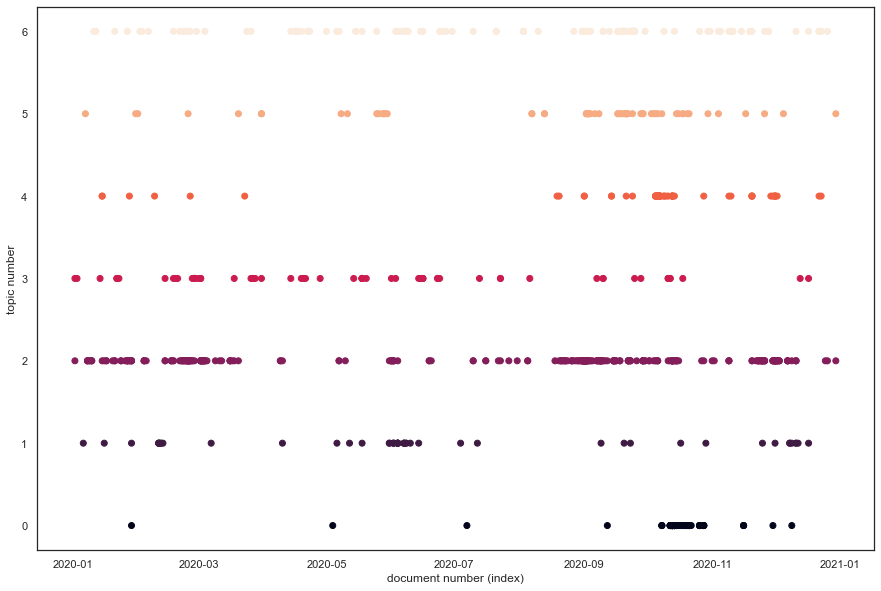

In [266]:
plt.figure(figsize=(15,10))
plt.scatter(x=data_df.date, y=data_df['topic_num'], c=data_df['topic_num'] )
plt.xlabel('document number (index)')
plt.ylabel('topic number')

In [231]:
# datetime.datetime.strptime('2018-05-19', '%Y-%m-%d')
data_df['date'] = data_df['date'].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))

In [241]:
# 각 토픽 별 해당하는 문서 번호(index) 삽입
num_topics = len(data_df.topic_num.unique())
topic_per_idx = [[] for i in range(num_topics)]
for i, topic_num in enumerate(data_df['topic_num']):
#     print(i,',',topic_num)
    topic_per_idx[topic_num].append(i)
#     print(topic_per_idx)

# 확인
for i, topic_idxs in enumerate(topic_per_idx):
    print(i, ':', len(topic_idxs))

0 : 89
1 : 48
2 : 317
3 : 70
4 : 65
5 : 61
6 : 122


In [248]:
# topic_div_idx : 토픽 별 월별 기사 인덱스 모음
MONTHS = 12 # 12개월
topic_month_idxs = [ [[] for i in range(MONTHS)] for j in range(len(topic_per_idx)) ]
# print(topic_div_idx)
for topic_num,idx_list in enumerate(topic_per_idx):
#     print(topic_num, ',', idx_list)
    for idx in idx_list:
        month = data_df['date'].iloc[idx].month-1
        topic_month_idxs[topic_num][month].append(idx)

# topic_div_idx 확인
for i in topic_month_idxs:
    print(i)

[[44], [], [], [], [182], [], [272], [], [410], [531, 533, 534, 544, 545, 546, 547, 549, 550, 551, 552, 554, 555, 556, 558, 559, 560, 562, 563, 564, 565, 566, 568, 570, 571, 572, 573, 574, 576, 577, 580, 583, 585, 591, 592, 593, 594, 595, 597, 598, 600, 601, 603, 605, 606, 607, 608, 609, 611, 615, 616, 617, 621, 622, 624, 628, 629, 630, 631, 632, 633, 634, 635, 637, 638, 639, 640, 642, 643, 644, 645, 646, 647, 648, 649, 650, 653, 655, 657, 658], [677, 678, 679, 716], [750]]
[[3, 19, 45], [57, 58, 59, 60, 61, 62, 63], [140], [166], [184, 192, 201, 212, 213], [220, 222, 225, 229, 230, 231, 232, 236, 238, 239, 240, 243, 248, 250, 251], [271, 276], [], [397, 444, 461], [623, 659], [700], [728, 746, 747, 748, 753, 755, 757, 760]]
[[1, 5, 6, 7, 8, 9, 10, 11, 12, 17, 20, 21, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 46], [51, 52, 53, 54, 64, 66, 67, 68, 69, 71, 73, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 104, 105, 106, 107, 117],

In [256]:
# 월별 기사의 양 확인
topic_mIdxs_cnt = [[[] for m in range(MONTHS)] for tnum in range(len(topic_month_idxs))]
for topic_num, idx_lists in enumerate(topic_month_idxs):
    for month, idx_list in enumerate(idx_lists):
        topic_mIdxs_cnt[topic_num][month] = (month,len(idx_list))
    print(topic_mIdxs_cnt[topic_num])
# topic_mIdxs_cnt

[(0, 1), (1, 0), (2, 0), (3, 0), (4, 1), (5, 0), (6, 1), (7, 0), (8, 1), (9, 80), (10, 4), (11, 1)]
[(0, 3), (1, 7), (2, 1), (3, 1), (4, 5), (5, 15), (6, 2), (7, 0), (8, 3), (9, 2), (10, 1), (11, 8)]
[(0, 29), (1, 36), (2, 26), (3, 3), (4, 4), (5, 12), (6, 8), (7, 26), (8, 88), (9, 28), (10, 30), (11, 27)]
[(0, 6), (1, 13), (2, 10), (3, 6), (4, 8), (5, 11), (6, 3), (7, 1), (8, 5), (9, 5), (10, 0), (11, 2)]
[(0, 3), (1, 2), (2, 1), (3, 0), (4, 0), (5, 0), (6, 0), (7, 2), (8, 6), (9, 36), (10, 8), (11, 7)]
[(0, 2), (1, 2), (2, 3), (3, 0), (4, 8), (5, 0), (6, 0), (7, 4), (8, 25), (9, 12), (10, 3), (11, 2)]
[(0, 4), (1, 11), (2, 3), (3, 8), (4, 8), (5, 18), (6, 3), (7, 8), (8, 38), (9, 5), (10, 10), (11, 6)]


In [265]:
# 토픽 내 상위 1~2 개월 구간 추출 
# - 조건: 토픽 내 문서 갯수 평균(m)보다 많고, 10개보다 큰 경우

topic_top_idxs = []

for idxlist in topic_mIdxs_cnt:
#     print(idxlist)
    srt_idxlist = sorted(idxlist, key= lambda x: x[1], reverse=True)
#     print(srt_idxlist)
    mean_idxlist = np.mean([x for _, x in tmp], dtype=int)
#     print(mean_idxlist)
    
    top_idxs = []
    for month, cnt in srt_idxlist:
#         print(month, ',', cnt)
        if (cnt > mean_idxlist) and (cnt>10):
            top_idxs.append((month, cnt))
    topic_top_idxs.append(top_idxs)
    print(top_idxs,'\n')

# topic_top_idxs


[(9, 80)] 

[(5, 15)] 

[(8, 88), (1, 36), (10, 30), (0, 29), (9, 28), (11, 27), (2, 26), (7, 26), (5, 12)] 

[(1, 13), (5, 11)] 

[(9, 36)] 

[(8, 25), (9, 12)] 

[(8, 38), (5, 18), (1, 11)] 



In [318]:
# 토픽 별 유사 기간의 문서를 묶어줌

topic_period_idxs = [[] for i in range(len(topic_month_idxs))]

for topic_num, top_idxs in enumerate(topic_top_idxs):
    top_idxs = sorted(top_idxs, key= lambda x: x[0])
    print(topic_num,':', top_idxs)
    for month, cnt in top_idxs:
        print('-- month:',month,', cnt:', cnt)
        print(topic_month_idxs[topic_num][month])
        set_idxs = set(topic_month_idxs[topic_num][month])
        # 현재 month의 시작과 끝 index
        curr_1stD_idx = topic_month_idxs[topic_num][month][0]
        print('curr_1stD_idx:', curr_1stD_idx)
        curr_lastD_idx = topic_month_idxs[topic_num][month][-1]
        print('curr_lastD_idx:',curr_lastD_idx)
        
        # 이전 구간의 마지막 문서의 날짜와 기간 간격 비교
        if (month>0) and (topic_mIdxs_cnt[topic_num][month-1][1]>0) :
            pre_lastD_idx = topic_month_idxs[topic_num][month-1][-1]
            print('pre_lastD_idx:',pre_lastD_idx)
        
            if timedelta(3) >= (data_df['date'].iloc[curr_1stD_idx]- data_df['date'].iloc[pre_lastD_idx]):
                print('pre/ timedelta(3)')
                print('data_df.date.iloc[',pre_lastD_idx,']:', data_df.date.iloc[pre_lastD_idx])
                print('data_df.date.iloc[',curr_1stD_idx,']:', data_df.date.iloc[curr_1stD_idx])
                set_idxs = set_idxs | set(topic_month_idxs[topic_num][month-1])

        # 다음 구간의 첫 번째 문서의 날짜와 기간 간격 비교
        if (month<11) and (topic_mIdxs_cnt[topic_num][month+1][1]>0) :
            nxt_1stD_idx = topic_month_idxs[topic_num][month+1][0]
            print('nxt_1stD_idx:',nxt_1stD_idx)
        
            if timedelta(3) >= (data_df['date'].iloc[nxt_1stD_idx]- data_df['date'].iloc[curr_lastD_idx]):
                print('nxt/ timedelta(3)')
                print('data_df.date.iloc[',curr_lastD_idx,']:', data_df.date.iloc[curr_lastD_idx])
                print('data_df.date.iloc[',nxt_1stD_idx,']:', data_df.date.iloc[nxt_1stD_idx])
                set_idxs = set_idxs | set(topic_month_idxs[topic_num][month+1])
                
        if (len(topic_period_idxs[topic_num]) > 0) and (0 < topic_num < len(topic_month_idxs)):
            if topic_period_idxs[topic_num][-1] & set_idxs:
                set_idxs = topic_period_idxs[topic_num][-1] | set_idxs
                del topic_period_idxs[topic_num][-1]
                
        
        topic_period_idxs[topic_num].append(set_idxs)
        print('\n\n')

0 : [(9, 80)]
-- month: 9 , cnt: 80
[531, 533, 534, 544, 545, 546, 547, 549, 550, 551, 552, 554, 555, 556, 558, 559, 560, 562, 563, 564, 565, 566, 568, 570, 571, 572, 573, 574, 576, 577, 580, 583, 585, 591, 592, 593, 594, 595, 597, 598, 600, 601, 603, 605, 606, 607, 608, 609, 611, 615, 616, 617, 621, 622, 624, 628, 629, 630, 631, 632, 633, 634, 635, 637, 638, 639, 640, 642, 643, 644, 645, 646, 647, 648, 649, 650, 653, 655, 657, 658]
curr_1stD_idx: 531
curr_lastD_idx: 658
pre_lastD_idx: 410
nxt_1stD_idx: 677



1 : [(5, 15)]
-- month: 5 , cnt: 15
[220, 222, 225, 229, 230, 231, 232, 236, 238, 239, 240, 243, 248, 250, 251]
curr_1stD_idx: 220
curr_lastD_idx: 251
pre_lastD_idx: 213
pre/ timedelta(3)
data_df.date.iloc[ 213 ]: 2020-05-31 00:00:00
data_df.date.iloc[ 220 ]: 2020-06-02 00:00:00
nxt_1stD_idx: 271



2 : [(0, 29), (1, 36), (2, 26), (5, 12), (7, 26), (8, 88), (9, 28), (10, 30), (11, 27)]
-- month: 0 , cnt: 29
[1, 5, 6, 7, 8, 9, 10, 11, 12, 17, 20, 21, 22, 23, 24, 26, 30, 31, 32, 33

In [319]:
# 확인
for i, t in enumerate(topic_period_idxs):
    print('Topic #',i,':',len(t),'구간\n',t,'\n-----\n')

Topic # 0 : 1 구간
 [{531, 533, 534, 544, 545, 546, 547, 549, 550, 551, 552, 554, 555, 556, 558, 559, 560, 562, 563, 564, 565, 566, 568, 570, 571, 572, 573, 574, 576, 577, 580, 583, 585, 591, 592, 593, 594, 595, 597, 598, 600, 601, 603, 605, 606, 607, 608, 609, 611, 615, 616, 617, 621, 622, 624, 628, 629, 630, 631, 632, 633, 634, 635, 637, 638, 639, 640, 642, 643, 644, 645, 646, 647, 648, 649, 650, 653, 655, 657, 658}] 
-----

Topic # 1 : 1 구간
 [{192, 201, 212, 213, 220, 222, 184, 225, 229, 230, 231, 232, 236, 238, 239, 240, 243, 248, 250, 251}] 
-----

Topic # 2 : 5 구간
 [{1, 5, 6, 7, 8, 9, 10, 11, 12, 17, 20, 21, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 46}, {51, 52, 53, 54, 64, 66, 67, 68, 69, 71, 73, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 104, 105, 106, 107, 117, 120, 121, 122, 123, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 141, 142, 143, 144, 145, 146, 147, 149, 151}, {224, 226, 261, 262, 263, 23

In [384]:
# 토픽별 기간(구간)별 대표 문서 번호 추출

topic_rep_idxs = []
for topic_num, period_list in enumerate(topic_period_idxs):
    print('=== ',topic_num, ' ===')
    topic_tmp = []
    for i in range(len(period_list)):
        print('--',i,'--\n')
        d_df = data_df['token_rhino'].iloc[list(topic_period_idxs[topic_num][i])].copy()
        d_df = d_df.reset_index()
        cnt_vect = CountVectorizer(lowercase=False)
        cnt_matrix = cnt_vect.fit_transform(d_df['token_rhino'].apply(lambda x : ' '.join(w for w in x)))
        similarity_pair = cosine_similarity(cnt_matrix, cnt_matrix)
        sorted_idx = similarity_pair.argsort()[:,::-1]
        sorted_idx = [str(j) for i in sorted_idx[:,1:3] for j in i] #  sorted_idx[:,1:3]
#         print('sorted_idx:\n',sorted_idx) 
        
        cnt_sorted_idx = Counter(sorted_idx)
        top_sim_idx = cnt_sorted_idx.most_common(1)
        print('top_sim_idx:', top_sim_idx)
        top_doc_idx = d_df['index'].iloc[int(top_sim_idx[0][0])]
        print('top_doc_idx:',top_doc_idx)
        
        topic_tmp.append(top_doc_idx)
    topic_rep_idxs.append(topic_tmp)

# 확인
print('\n\n=== topic : 대표문서 번호 ===\n')
for t_n, idx in enumerate(topic_rep_idxs):
    print('Topic #',t_n,':', idx)
        
        

===  0  ===
-- 0 --

top_sim_idx: [('32', 14)]
top_doc_idx: 585
===  1  ===
-- 0 --

top_sim_idx: [('15', 7)]
top_doc_idx: 240
===  2  ===
-- 0 --

top_sim_idx: [('2', 9)]
top_doc_idx: 6
-- 1 --

top_sim_idx: [('14', 7)]
top_doc_idx: 80
-- 2 --

top_sim_idx: [('1', 5)]
top_doc_idx: 226
-- 3 --

top_sim_idx: [('113', 11)]
top_doc_idx: 419
-- 4 --

top_sim_idx: [('36', 10)]
top_doc_idx: 727
===  3  ===
-- 0 --

top_sim_idx: [('6', 6)]
top_doc_idx: 156
-- 1 --

top_sim_idx: [('10', 5)]
top_doc_idx: 254
===  4  ===
-- 0 --

top_sim_idx: [('13', 6)]
top_doc_idx: 529
===  5  ===
-- 0 --

top_sim_idx: [('23', 9)]
top_doc_idx: 378
-- 1 --

top_sim_idx: [('9', 5)]
top_doc_idx: 661
===  6  ===
-- 0 --

top_sim_idx: [('7', 4)]
top_doc_idx: 118
-- 1 --

top_sim_idx: [('12', 4)]
top_doc_idx: 245
-- 2 --

top_sim_idx: [('31', 6)]
top_doc_idx: 470


=== topic : 대표문서 번호 ===

Topic # 0 : [585]
Topic # 1 : [240]
Topic # 2 : [6, 80, 226, 419, 727]
Topic # 3 : [156, 254]
Topic # 4 : [529]
Topic # 5 : [378

In [390]:
# 대표 문서 추출
ext_data = data_df.iloc[[i for t in topic_rep_idxs for i in t]].copy()

In [392]:
ext_data

,media,date,title,article_original,url,token_rhino,topic_num
585,조선일보,2020-10-13,NYT 중국 네티즌 BTS 악의 없는 발언에도 공격,로이터 에선 삼성 앞에 정치적 지뢰 있다 미국 뉴욕타임스 NYT 는 12일 현지...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[로이터, 삼성, 정치적, 지뢰, 미국, 뉴욕타임스, 현지, 시각, 방탄소년단, 악...",0
240,경향신문,2020-06-07,방탄소년단소속사 흑인 인권 캠페인에 12억 기부,경향신문 그룹 방탄소년단 BTS 과 소속사 빅히트엔터테인먼트가 흑인 인권운동 캠...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 그룹, 방탄소년단, 소속사, 빅히트엔터테인먼트, 흑인, 인권운동, 캠페...",1
6,경향신문,2020-01-08,방탄소년단 2월21일 새 앨범으로 돌아온다,그룹 방탄소년단 BTS 이 다음 달 21일 새 앨범으로 돌아온다 소속사 빅히트엔터...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄소년단, 다음, 앨범, 소속사, 빅히트엔터테인먼트, 오전, 커뮤니티, ...",2
80,조선일보,2020-02-22,방탄소년단 새 앨범 91개국 아이튠즈 1위 역대 최고기록,그룹 방탄소년단 BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄소년단, 앨범, 세계, 지역, 아이, 차트, 방탄소년단, 앨범, 역대,...",2
226,조선일보,2020-06-02,BTS 슈가 빌보드 200 11위 한국 솔로 앨범 최고 기록,사이비 교주 육성 삽입 논란도 그룹 방탄소년단 BTS 멤버 슈가의 개인 믹스테이...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[사이비, 교주, 육성, 삽입, 논란, 그룹, 방탄소년단, 멤버, 슈가, 개인, 믹...",2
419,경향신문,2020-09-15,방탄소년단 미국 빌보드 싱글 차트 2위3주째 최상위권,경향신문 그룹 방탄소년단 BTS 의 다이너마이트 Dynamite 가 미국 빌보드...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 그룹, 방탄소년단, 다이너마이트, 미국, 빌보드, 메인, 싱글, 차트,...",2
727,경향신문,2020-12-01,방탄소년단 이번엔 한국어 곡으로 빌보드 싱글차트 정상에,경향신문 그룹 방탄소년단 BTS 의 신곡 라이프 고스 온이 미국 빌보드 메인 싱...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 그룹, 방탄소년단, 신곡, 라이프, 고스, 미국, 빌보드, 메인, 싱글...",2
156,경향신문,2020-03-27,방탄소년단 코로나19 확산에 북미 투어 연기,그룹 방탄소년단 BTS 이 코로나19 확산으로 북미 투어 일정을 연기한다 소속사 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄소년단, 코로나, 확산, 북미, 투어, 일정, 소속사, 빅히트엔터테인먼...",3
254,경향신문,2020-06-15,BTS 온라인 콘서트 방방콘 The Live로 107개 지역 75만 아미 만났다,경향신문 그룹 방탄소년단이 실시간 라이브 공연 방방콘 The Live 를 열어 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 그룹, 방탄소년단, 실시간, 라이브, 공연, 방방콘, 아미, 뜨겁, 교...",3
529,중앙일보,2020-10-07,아미도 냅두라는데BTS 병역특례 2년만에 다시 띄우는,BTS를 병역특례 해주자는 입장이 아니다 순수예술인은 특례대상인데 대중예술인은 아닌...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[병역특례, 입장, 순수예술인, 특례, 상인, 대중예술인, 형평, 문제, 사례, 제...",4


In [443]:
ext_data.reset_index(inplace=True)

In [452]:
ext_data.rename(columns={'index':'doc_index'}, inplace=True)

In [438]:
from gensim.summarization.summarizer import summarize
import kss

In [469]:
# text (str) – 요약할 테스트.
# ratio (float, optional) – 요약에 대해 선택할 원본 텍스트의 문장 수 비율을 결정하는 0~1 사이 숫자.
# word_count (int or None, optional) – 출력에 포함할 단어 수. 두 파라미터가 모두 제공되는 경우 ratio는 무시된다.
# split (bool, optional) – True면 문장 list가 반환된다. False는 조인(join)된 문자열이 반환된다.
ext_data['summarize'] = ext_data['article_original'].apply(lambda x : summarize('. '.join(kss.split_sentences(x)), word_count = 100))

2021-02-22 05:54:06,110 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-22 05:54:06,110 : INFO : built Dictionary(108 unique tokens: ['bt', '돌아온다', '방탄소년단', '앨범으로', 'map']...) from 10 documents (total 129 corpus positions)
2021-02-22 05:54:06,111 : INFO : Building graph
2021-02-22 05:54:06,111 : INFO : Filling graph
2021-02-22 05:54:06,113 : INFO : Removing unreachable nodes of graph
2021-02-22 05:54:06,113 : INFO : Pagerank graph
2021-02-22 05:54:06,116 : INFO : Sorting pagerank scores
2021-02-22 05:54:06,188 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-22 05:54:06,189 : INFO : built Dictionary(78 unique tokens: ['bt', '발매하자마자', '방탄소년단', '아이튠즈', '앨범이']...) from 14 documents (total 91 corpus positions)
2021-02-22 05:54:06,190 : INFO : Building graph
2021-02-22 05:54:06,191 : INFO : Filling graph
2021-02-22 05:54:06,192 : INFO : Removing unreachable nodes of graph
2021-02-22 05:54:06,193 : INFO : Pagerank graph
2021-02-22 05:54:06,196 : I

In [470]:
ext_data = ext_data.sort_values(by='date')
ext_data.reset_index(drop=True, inplace=True)

In [471]:
ext_data

,doc_index,media,date,title,article_original,url,token_rhino,topic_num,summarize
0,6,경향신문,2020-01-08,방탄소년단 2월21일 새 앨범으로 돌아온다,그룹 방탄소년단 BTS 이 다음 달 21일 새 앨범으로 돌아온다 소속사 빅히트엔터...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄소년단, 다음, 앨범, 소속사, 빅히트엔터테인먼트, 오전, 커뮤니티, ...",2,그룹 방탄소년단 BTS 이 다음 달 21일 새 앨범으로 돌아온다.\n방탄소년단 리더...
1,80,조선일보,2020-02-22,방탄소년단 새 앨범 91개국 아이튠즈 1위 역대 최고기록,그룹 방탄소년단 BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄소년단, 앨범, 세계, 지역, 아이, 차트, 방탄소년단, 앨범, 역대,...",2,그룹 방탄소년단 BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위...
2,118,중앙일보,2020-02-29,영상트럼프도 엄두 못낸 특혜 BTS 투나잇쇼 전세냈다,오늘은 특별한 날입니다 초대 손님을 딱 한 팀만 모셨어요 세계 최고 밴드인 BTS와...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[오늘, 특별, 초대, 손님, 세계, 최고, 밴드, 시간, 동안, 현지시간, 미국,...",6,지난 24일 현지시간 미국 동부시간으로 밤 11시 30분 NBC방송 토크쇼인 더 투...
3,156,경향신문,2020-03-27,방탄소년단 코로나19 확산에 북미 투어 연기,그룹 방탄소년단 BTS 이 코로나19 확산으로 북미 투어 일정을 연기한다 소속사 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄소년단, 코로나, 확산, 북미, 투어, 일정, 소속사, 빅히트엔터테인먼...",3,빅히트는 영문 공지를 내고 관련된 모두의 안전을 최우선으로 하기 위해서 다가오는 북...
4,226,조선일보,2020-06-02,BTS 슈가 빌보드 200 11위 한국 솔로 앨범 최고 기록,사이비 교주 육성 삽입 논란도 그룹 방탄소년단 BTS 멤버 슈가의 개인 믹스테이...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[사이비, 교주, 육성, 삽입, 논란, 그룹, 방탄소년단, 멤버, 슈가, 개인, 믹...",2,사이비 교주 육성 삽입 논란도 그룹 방탄소년단 BTS 멤버 슈가의 개인 믹스테이프...
5,240,경향신문,2020-06-07,방탄소년단소속사 흑인 인권 캠페인에 12억 기부,경향신문 그룹 방탄소년단 BTS 과 소속사 빅히트엔터테인먼트가 흑인 인권운동 캠...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 그룹, 방탄소년단, 소속사, 빅히트엔터테인먼트, 흑인, 인권운동, 캠페...",1,경향신문 그룹 방탄소년단 BTS 과 소속사 빅히트엔터테인먼트가 흑인 인권운동 캠...
6,245,경향신문,2020-06-08,방탄소년단의 온라인 축사 우리도 서툰 20대우리가 위로와 희망이 되고 싶다,경향신문 그룹 방탄소년단 BTS 이 코로나19 확산으로 오프라인 졸업식에 가지 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 그룹, 방탄소년단, 코로나, 확산, 오프라인, 졸업식, 졸업, 축사, ...",6,BTS는 한국시간으로 8일 오전 4시 유튜브로 중계된 가상 졸업식 디어 클래스 오브...
7,254,경향신문,2020-06-15,BTS 온라인 콘서트 방방콘 The Live로 107개 지역 75만 아미 만났다,경향신문 그룹 방탄소년단이 실시간 라이브 공연 방방콘 The Live 를 열어 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 그룹, 방탄소년단, 실시간, 라이브, 공연, 방방콘, 아미, 뜨겁, 교...",3,공연은 방탄소년단의 방으로 팬들을 초대하는 콘셉트로 다양한 분위기로 꾸며진 무대를 ...
8,378,경향신문,2020-09-03,빅히트 공모주 청약 앞두고 BTS에 주식 증여상장 시 1인당 최대 200억원대,경향신문 방탄소년단 BTS 이 소속사인 빅히트엔터테인먼트로부터 1인당 7만주 가...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 방탄소년단, 소속사, 빅히트엔터테인먼트, 가깝, 보통주, 증여, 빅히트...",5,3일 금융감독원 전자공시시스템 DART 에 올라온 빅히트 증권신고서에 따르면 최대 ...
9,419,경향신문,2020-09-15,방탄소년단 미국 빌보드 싱글 차트 2위3주째 최상위권,경향신문 그룹 방탄소년단 BTS 의 다이너마이트 Dynamite 가 미국 빌보드...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[경향신문, 그룹, 방탄소년단, 다이너마이트, 미국, 빌보드, 메인, 싱글, 차트,...",2,빌보드는 14일 이하 현지시간 방탄소년단 다이너마이트가 메인 싱글 차트인 핫 100...


In [473]:
for i in range(ext_data.shape[0]):
    print('---', ext_data['date'][i],' / ',ext_data['topic_num'][i], '---')
    print(ext_data['summarize'].iloc[i],'\n')
    

--- 2020-01-08 00:00:00  /  2 ---
그룹 방탄소년단 BTS 이 다음 달 21일 새 앨범으로 돌아온다.
방탄소년단 리더 RM은 지난해 말 미국 연예매체 버라이어티 주최 시상식에서 좋은 소식은 우리가 새로운 음악 새로운 앨범을 작업하고 있다는 것이라며 가까운 장래에 여러분과 공유할 것이 기대된다고 말한 바 있다.
방탄소년단의 새 앨범은 지난해 4월 맵 오브 더 솔 연작의 첫 앨범인 맵 오브 더 솔 페르소나 MAP OF THE SOUL PERSONA 이후 약 10개월 만이다.
방탄소년단은 앞서 러브 유어셀프 전 티어 LOVE YOURSELF  Tear 와 러브 유어셀프 결 앤서 LOVE YOURSELF  Answer 까지 3장 앨범을 11개월 사이 빌보드 200 정상에 올려놨다 

--- 2020-02-22 00:00:00  /  2 ---
그룹 방탄소년단 BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위를 휩쓸었다.
22일 소속사 빅히트엔터테인먼트에 따르면 BTS가 전날 발매한 정규 4집 맵 오브 더 솔 7 MAP OF THE SOUL 7 은 이날 오전 10시 기준 미국 캐나다 영국 프랑스 등 91개국 아이튠즈의 톱앨범 차트에서 1위를 기록했다.
새 앨범 타이틀곡 온 ON 도 미국 캐나다 영국 프랑스 이탈리아 러시아 일본 이집트 등 83개 국가 및 지역 아이튠즈 톱 송 차트에서 1위를 차지했다.
방탄소년단은 앨범 판매량에서도 신기록을 세웠다.
국내 음반판매량 집계사이트 한터차트에 따르면 맵 오브 더 솔 7 앨범은 발매 당일인 21일 하루동안 265만3050장이 팔렸다.
방탄소년단은 3억뷰 돌파 뮤직비디오 12편 를 가장 많이 보유한 한국 가수가 됐다 

--- 2020-02-29 00:00:00  /  6 ---
지난 24일 현지시간 미국 동부시간으로 밤 11시 30분 NBC방송 토크쇼인 더 투나잇 쇼 스타링 지미 팰런이 방송됐다 사회자 겸 프로듀서인 지미 팰런은 흥분된 목소리로 이날 방송이 얼마나 특별한지를 거듭 강조했